# Wifi Localization Classification dataset

## Code

In [3]:
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from functools import partial
from sklearn import tree

## Sort data

In [12]:
#sort data
wifi_localdata = pd.read_csv("./Wifi localization data/wifi_localization.txt", sep='\t',names=['Wifi signal 1', 'Wifi signal 2', 'Wifi signal 3',
                                                                                        'Wifi signal 4', 'Wifi signal 5', 'Wifi signal 6',
                                                                                        'Wifi signal 7', 'Room location'])
wifi_localdata['Room location'] = wifi_localdata['Room location'].replace({1:1, 2:1, 3:0, 4:0})

## What the data looks like after cleaning

In [13]:
print(wifi_localdata['Room location'].value_counts())
wifi_localdata
#really good in that they are balanced.

Room location
1    1000
0    1000
Name: count, dtype: int64


,Wifi signal 1,Wifi signal 2,Wifi signal 3,Wifi signal 4,Wifi signal 5,Wifi signal 6,Wifi signal 7,Room location
0,-64,-56,-61,-66,-71,-82,-81,1
1,-68,-57,-61,-65,-71,-85,-85,1
2,-63,-60,-60,-67,-76,-85,-84,1
3,-61,-60,-68,-62,-77,-90,-80,1
4,-63,-65,-60,-63,-77,-81,-87,1
...,...,...,...,...,...,...,...,...
1995,-59,-59,-48,-66,-50,-86,-94,0
1996,-59,-56,-50,-62,-47,-87,-90,0
1997,-62,-59,-46,-65,-45,-87,-88,0
1998,-62,-58,-52,-61,-41,-90,-85,0


In [37]:
#get X,Y for sake of training later.
XY = wifi_localdata.values
X = XY[:,:-1]
y = XY[:,-1]
print(XY.shape)
print(X.shape)
print(y.shape)


(2000, 8)
(2000, 7)
(2000,)


## Partition data sets, visualize dataset partitions for sanity check!

In [38]:
#Data partitions (0.8/0.2 training-data, 0.5/0.5 training-to-data, 0.2/0.8 training-to-data)


#80-20 split
Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#50-50 split
Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#20-80 split
Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)



In [39]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == 0).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1],
                c='blue', label='Not the first 2 rooms')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1],
                c='red', label='First 2 rooms')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

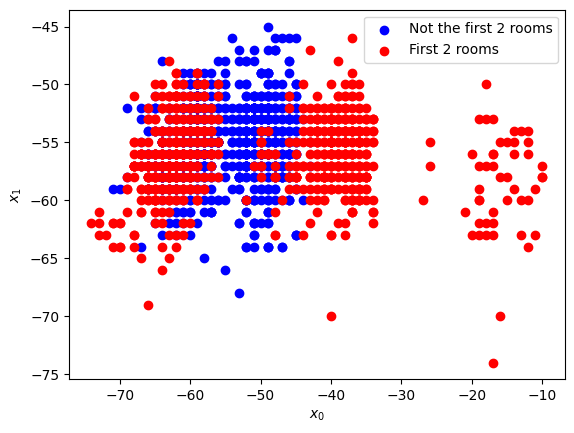

In [40]:
#more visualization
#Visualize training set as a sanity check; classes (0,1) are being plotted.
vis(Split1X_train, Split1y_train)

# Classifiers

## Partition: 80/20 set

Partition: 0.8
Train Accuracy: 0.97375
Validation Accuracy: 0.9649999999999999


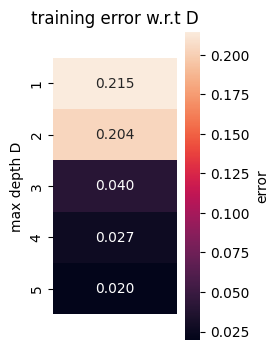

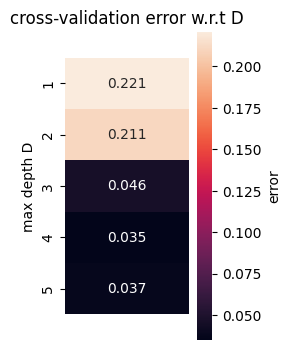

Best max depth D: 4
Test error: 0.030000000000000027
Train Accuracy: 0.978125
Validation Accuracy: 0.9706250000000001


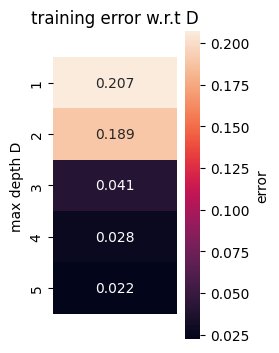

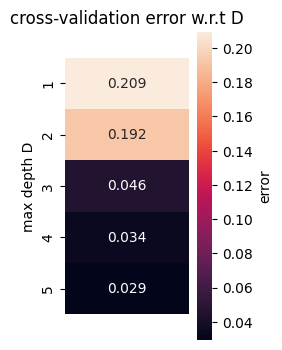

Best max depth D: 5
Test error: 0.030000000000000027
Train Accuracy: 0.978125
Validation Accuracy: 0.96


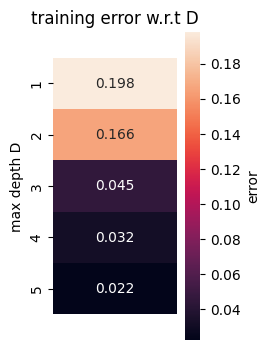

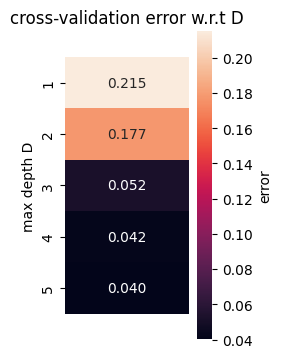

Best max depth D: 5
Test error: 0.022499999999999964


In [41]:
### Decision Tree ###
DTtestAccuracy_List1=[]
DTtestAccuracy_ListOverall = []
partitions = [0.8]
DTbest_max_depth_overall = 0
DT_best_accuracy = 0
trial = 3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split1X_train, Split1y_train)
        DTtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))


Partition: 0.8
Train Accuracy: 0.9875
Validation Accuracy: 0.9806250000000001


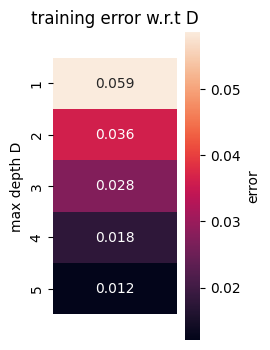

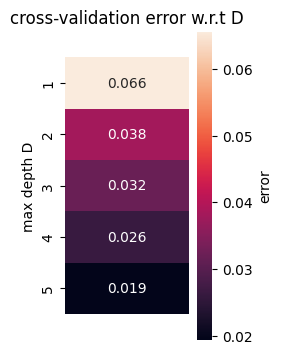

Best max depth D: 5
Test error: 0.022499999999999964
Train Accuracy: 0.9875
Validation Accuracy: 0.98125


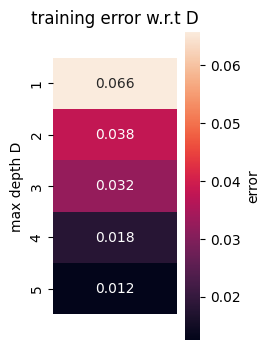

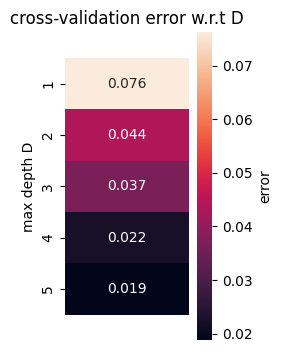

Best max depth D: 5
Test error: 0.025000000000000022
Train Accuracy: 0.9875
Validation Accuracy: 0.9800000000000001


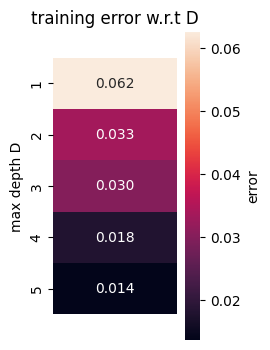

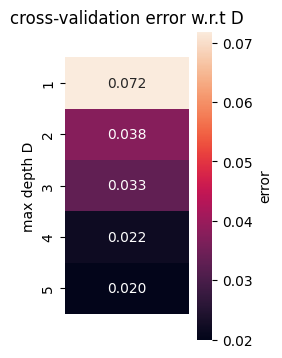

Best max depth D: 5
Test error: 0.02749999999999997


In [42]:
### Random Forests ###
RFtestAccuracy_List1=[]
RFtestAccuracy_ListOverall = []
partitions = [0.8]
RFbest_max_depth_overall = 0
RF_best_accuracy = 0
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split1X_train, Split1y_train)
        RFtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))
        

Partition: 0.8
Train Accuracy: 0.99
Validation Accuracy: 0.9862499999999998


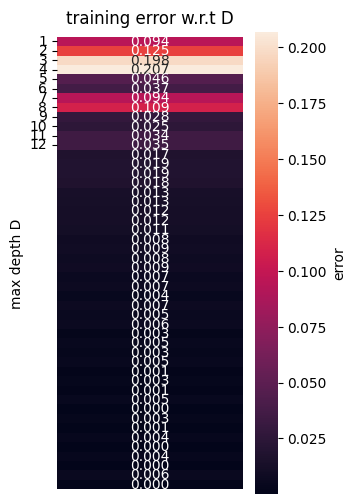

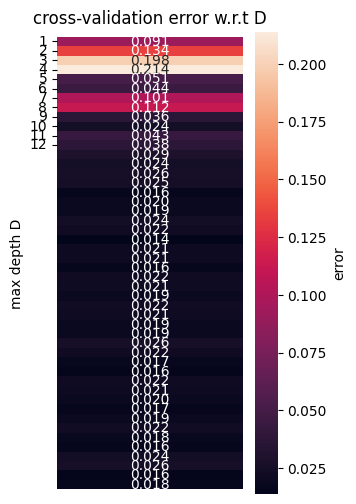

Best max depth D: 6
Test error: 0.025000000000000022
Train Accuracy: 0.999375
Validation Accuracy: 0.985625


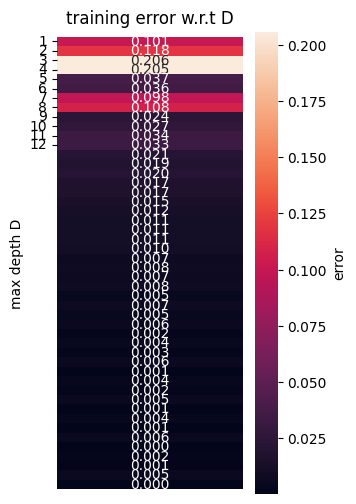

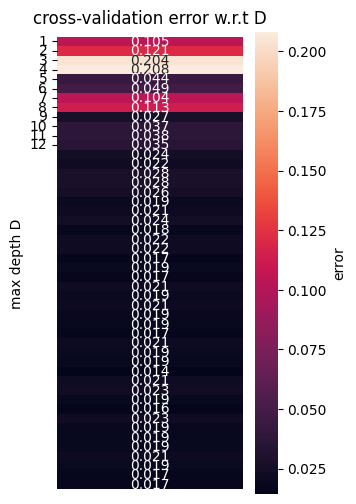

Best max depth D: 9
Test error: 0.022499999999999964
Train Accuracy: 0.99625
Validation Accuracy: 0.98375


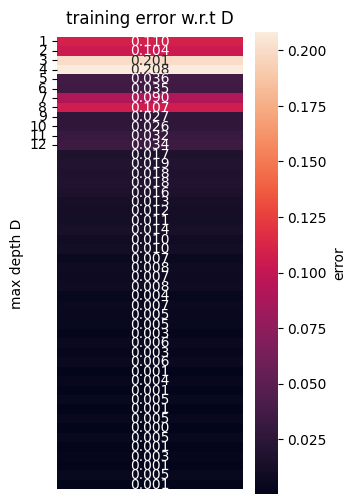

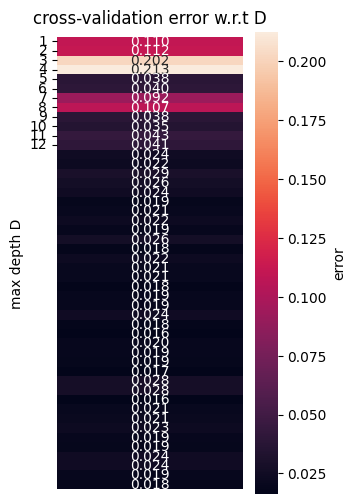

Best max depth D: 8
Test error: 0.022499999999999964


In [43]:
### Bagging family ###
BFtestAccuracy_List1=[]
BFtestAccuracy_ListOverall = []
partitions = [0.8]
BFbest_max_depth_overall = None
BF_best_accuracy = 0
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split1X_train, Split1y_train)
        BFtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))

Partition: 0.8
Best C: 10, Best Gamma: 0.001
Train Accuracy: 0.988125
Validation Accuracy: 0.9862500000000001


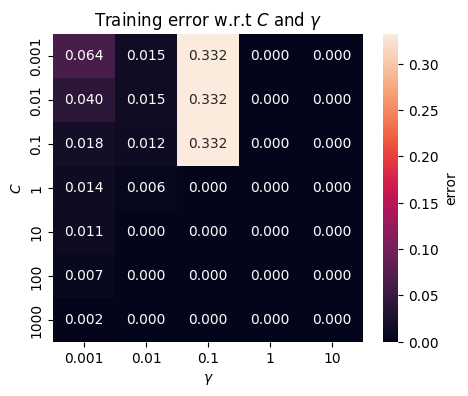

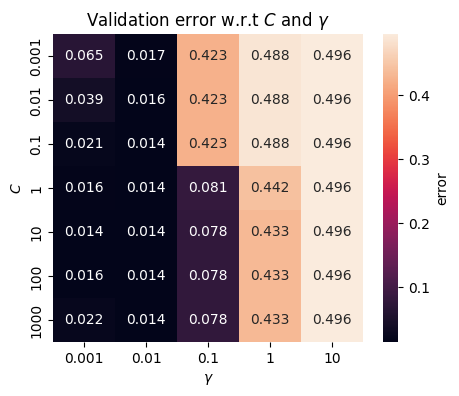

Best C: 0.1, Best Gamma: 0.01
Train Accuracy: 0.98625
Validation Accuracy: 0.9862500000000001


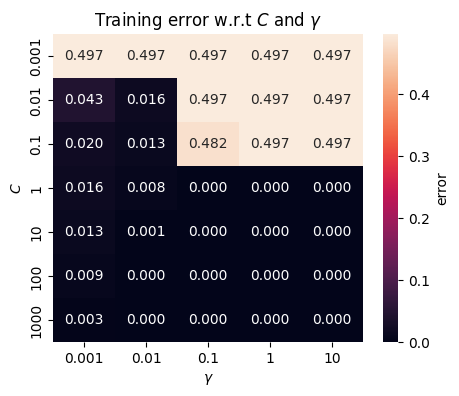

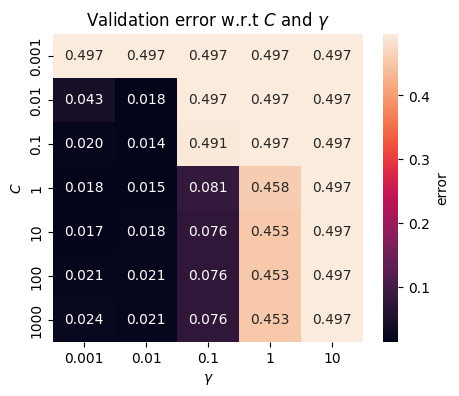

Best C: 0.1, Best Gamma: 0.01
Train Accuracy: 0.989375
Validation Accuracy: 0.9862500000000001


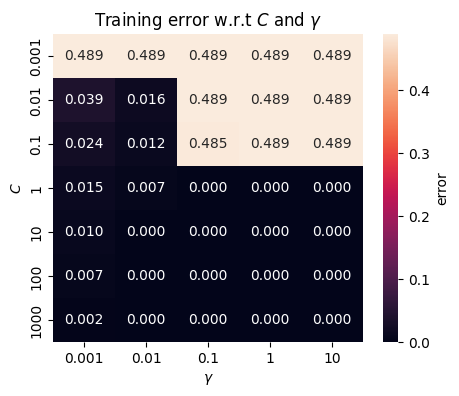

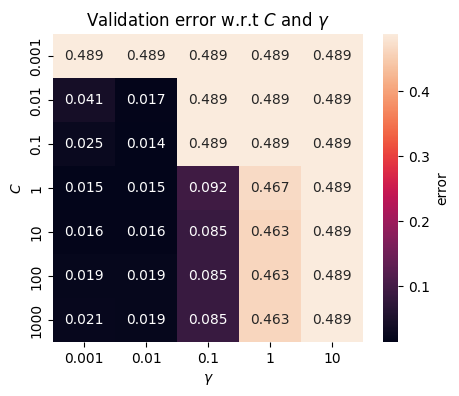

In [44]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.8]
trial = 3
testAccuracy_List1=[]
testAccuracy_ListOverall = []
training_errors = np.zeros((len(C_list), len(gamma_list)))
best_training_accuracy =0
best_C_overall = 0
best_gamma_overall = 0

#run 3 trials per partition
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split1X_train, Split1y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']


        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")

        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = classifier_Search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma


        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
    
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split1X_train, Split1y_train)
        testAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        testAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))




## Partition: 50/50 set

Partition: 0.5
Train Accuracy: 0.982
Validation Accuracy: 0.9650000000000001


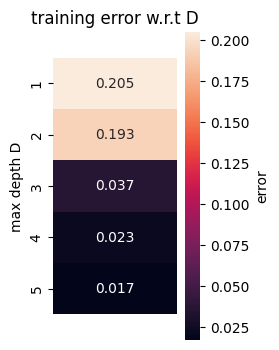

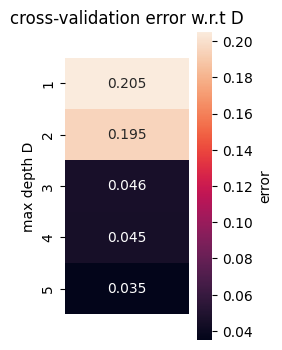

Best max depth D: 5
Test error: 0.04200000000000004
Train Accuracy: 0.98
Validation Accuracy: 0.9620000000000001


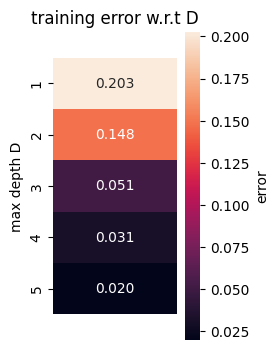

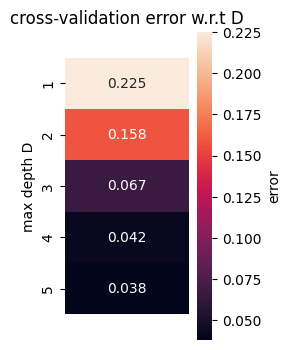

Best max depth D: 5
Test error: 0.03500000000000003
Train Accuracy: 0.978
Validation Accuracy: 0.9710000000000001


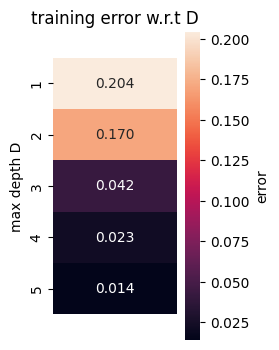

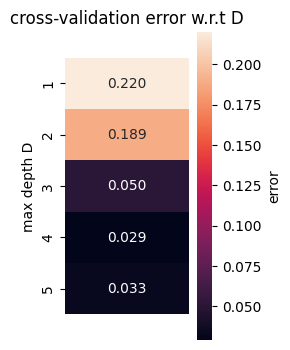

Best max depth D: 4
Test error: 0.03700000000000003


In [45]:
### Decision Tree ###
DTtestAccuracy_List2=[]
partitions = [0.5]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split2X_train, Split2y_train)
        DTtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))

Partition: 0.5
Train Accuracy: 0.992
Validation Accuracy: 0.983


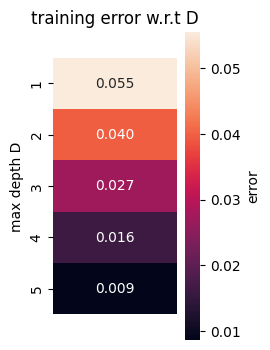

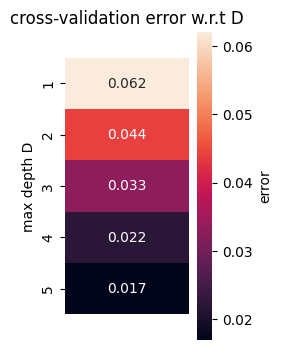

Best max depth D: 5
Test error: 0.02400000000000002
Train Accuracy: 0.99
Validation Accuracy: 0.984


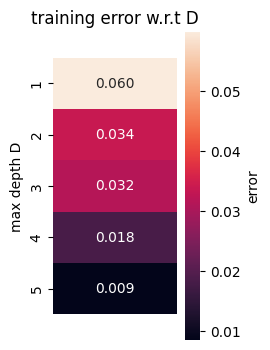

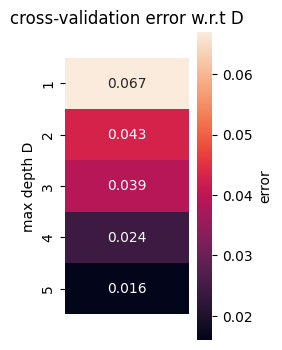

Best max depth D: 5
Test error: 0.025000000000000022
Train Accuracy: 0.991
Validation Accuracy: 0.983


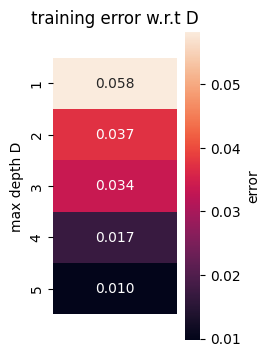

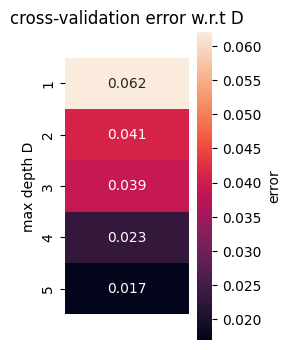

Best max depth D: 5
Test error: 0.02200000000000002


In [46]:
### Random Forests ###
RFtestAccuracy_List2=[]
partitions = [0.5]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split2X_train, Split2y_train)
        RFtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))
        

Partition: 0.5
Train Accuracy: 0.995
Validation Accuracy: 0.983


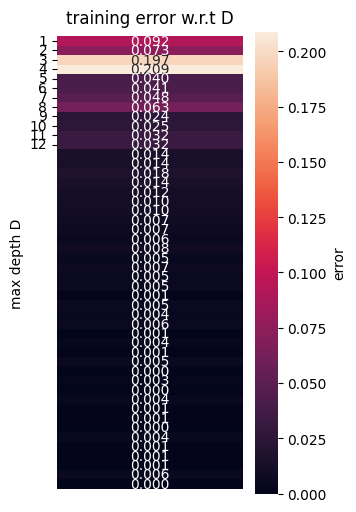

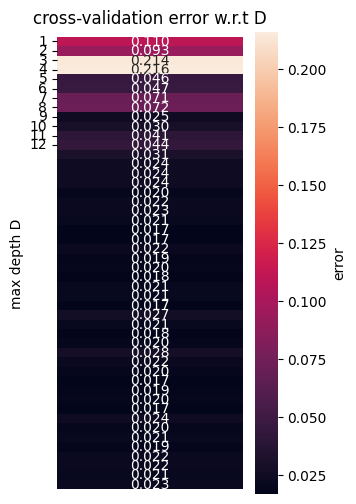

Best max depth D: 6
Test error: 0.030000000000000027
Train Accuracy: 0.998
Validation Accuracy: 0.982


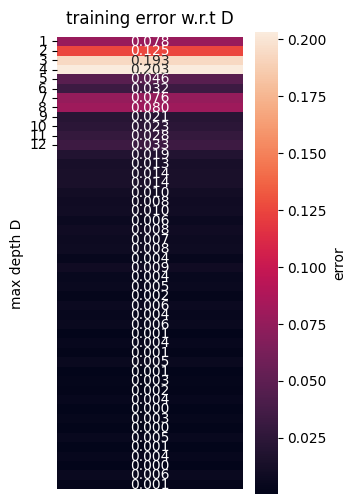

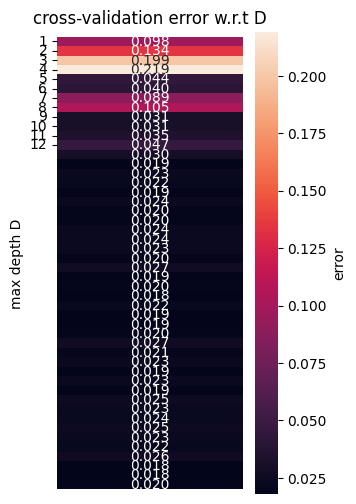

Best max depth D: 7
Test error: 0.02100000000000002
Train Accuracy: 0.994
Validation Accuracy: 0.983


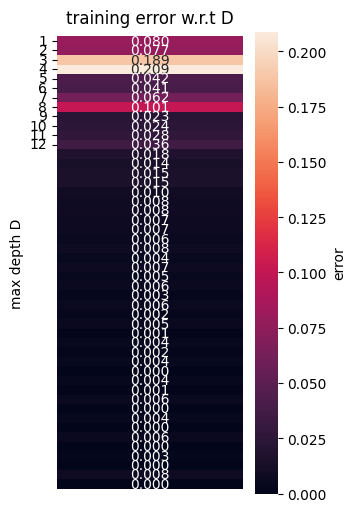

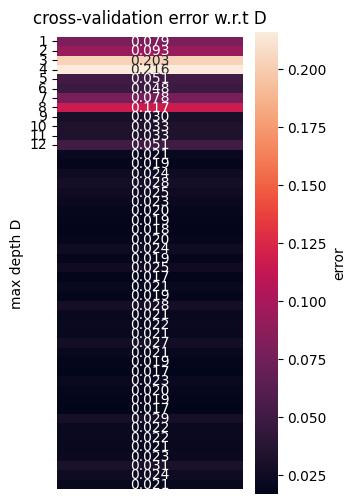

Best max depth D: 7
Test error: 0.027000000000000024


In [47]:
### Bagging family ###
BFtestAccuracy_List2=[]
partitions = [0.5]

for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split2X_train, Split2y_train)
        BFtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))

Partition: 0.5
Best C: 1, Best Gamma: 0.01
Train Accuracy: 0.995
Validation Accuracy: 0.9890000000000001


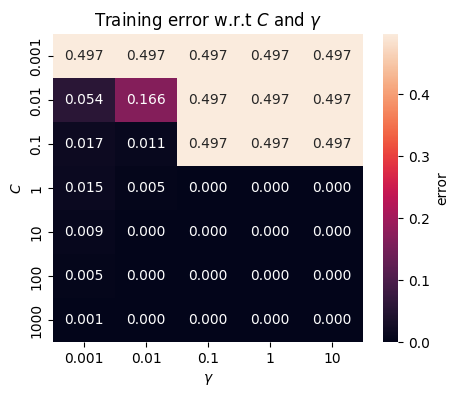

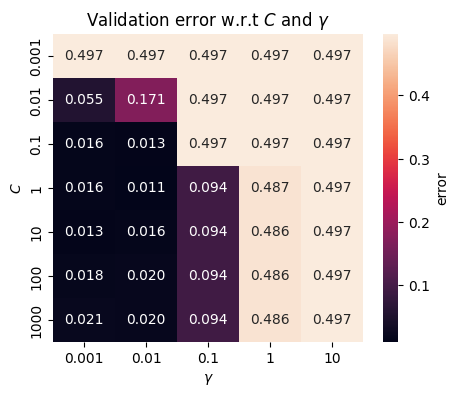

Best C: 0.1, Best Gamma: 0.01
Train Accuracy: 0.987
Validation Accuracy: 0.985


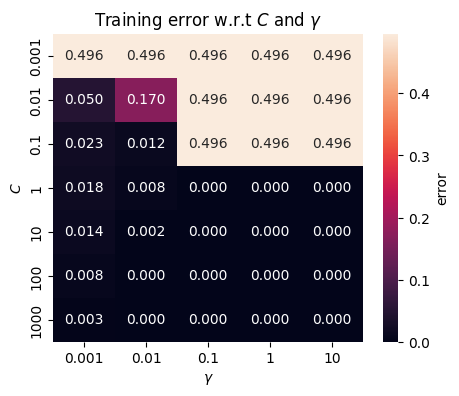

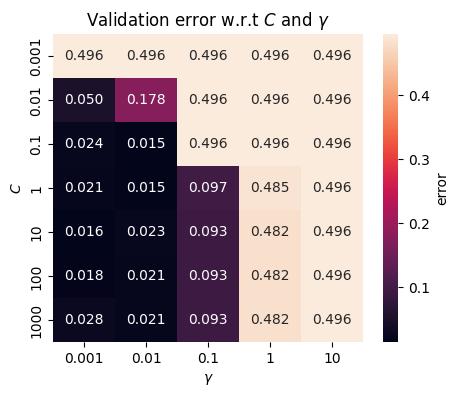

Best C: 1, Best Gamma: 0.01
Train Accuracy: 0.997
Validation Accuracy: 0.991


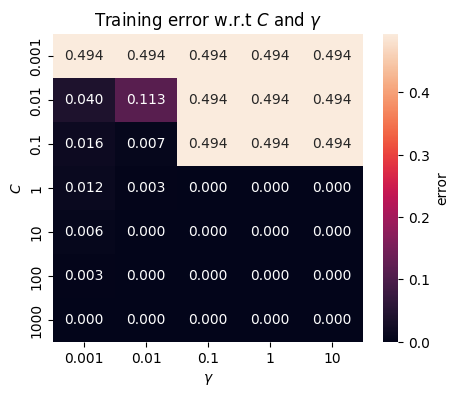

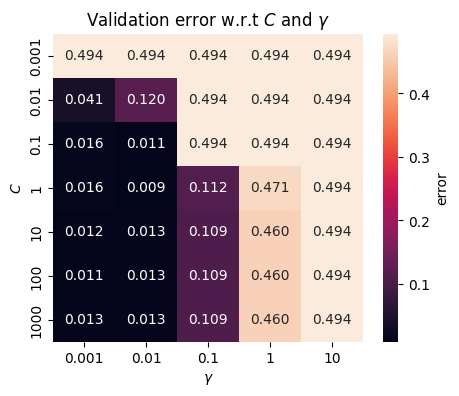

In [48]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.5]
trial = 3
testAccuracy_List2=[]
training_errors = np.zeros((len(C_list), len(gamma_list)))


#run 3 trials per partition
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=i)

        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split2X_train, Split2y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']

        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")


        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = classifier_Search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')

        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma

        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        bestC= classifier_Search.best_params_['C']
        bestGamma= classifier_Search.best_params_['gamma']
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split2X_train, Split2y_train)
        testAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        testAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))


## Partition: 20/80 set

Partition: 0.2
Train Accuracy: 0.985
Validation Accuracy: 0.945


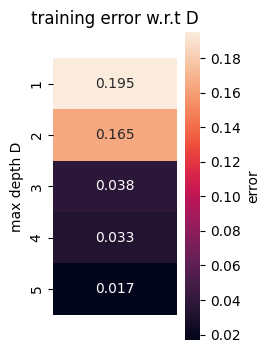

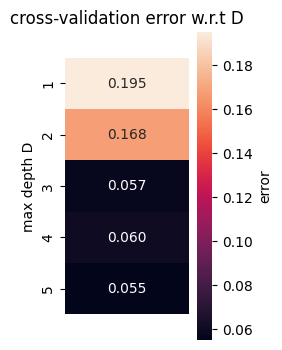

Best max depth D: 5
Test error: 0.03749999999999998
Train Accuracy: 0.99
Validation Accuracy: 0.95


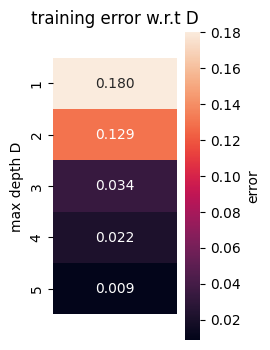

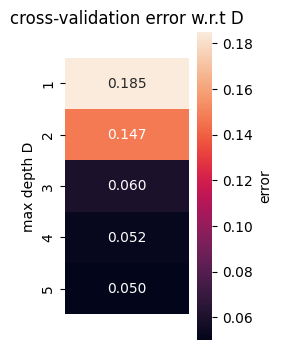

Best max depth D: 5
Test error: 0.06437499999999996
Train Accuracy: 0.985
Validation Accuracy: 0.9724999999999999


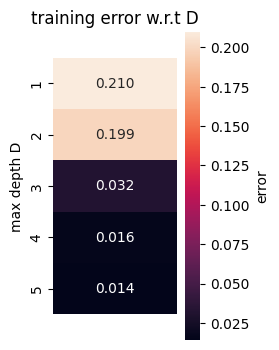

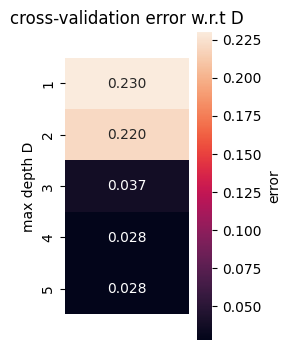

Best max depth D: 4
Test error: 0.03937500000000005


In [49]:
### Decision Tree ###
DTtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split3X_train, Split3y_train)
        DTtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))

Partition: 0.2
Train Accuracy: 0.9925
Validation Accuracy: 0.9724999999999999


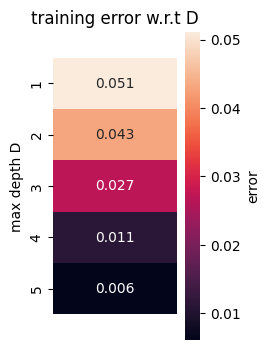

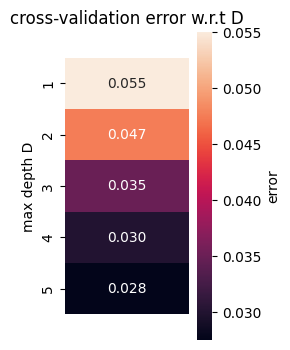

Best max depth D: 5
Test error: 0.028124999999999956
Train Accuracy: 0.995
Validation Accuracy: 0.97


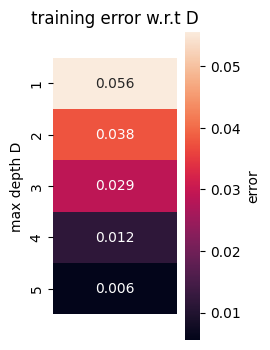

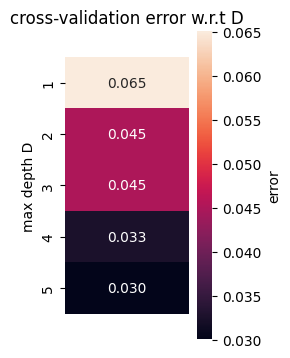

Best max depth D: 5
Test error: 0.026874999999999982
Train Accuracy: 0.9925
Validation Accuracy: 0.9724999999999999


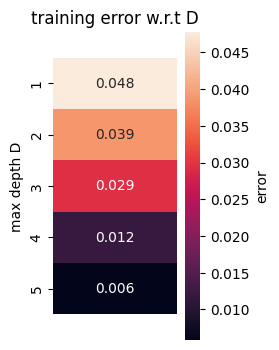

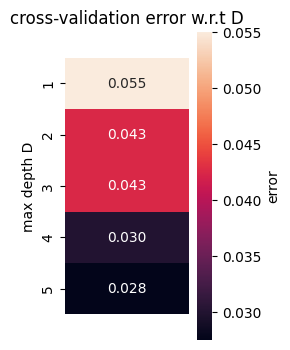

Best max depth D: 5
Test error: 0.02749999999999997


In [50]:
### Random Forests ###
RFtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split3X_train, Split3y_train)
        RFtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))
        

Partition: 0.2
Train Accuracy: 0.9975
Validation Accuracy: 0.9850000000000001


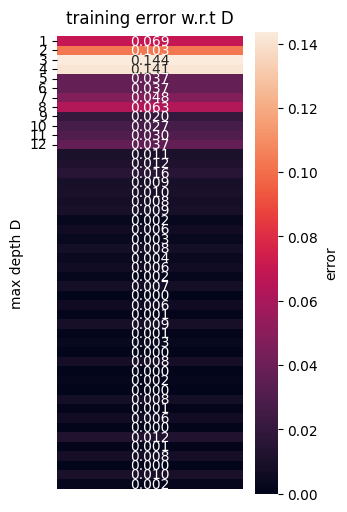

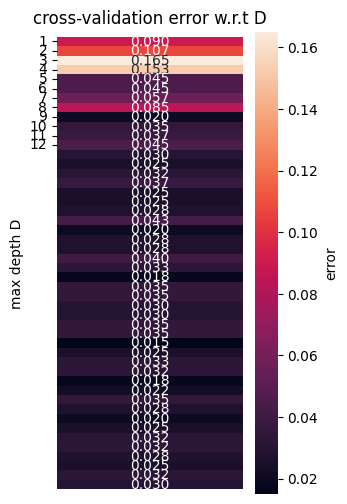

Best max depth D: 9
Test error: 0.02749999999999997
Train Accuracy: 0.9925
Validation Accuracy: 0.9875


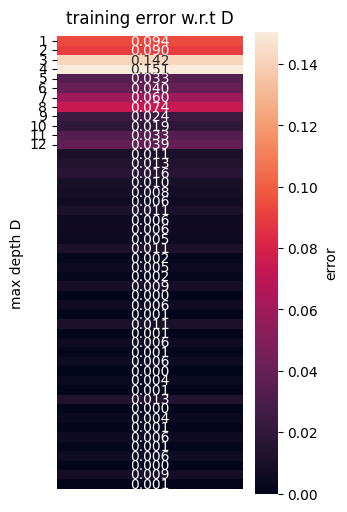

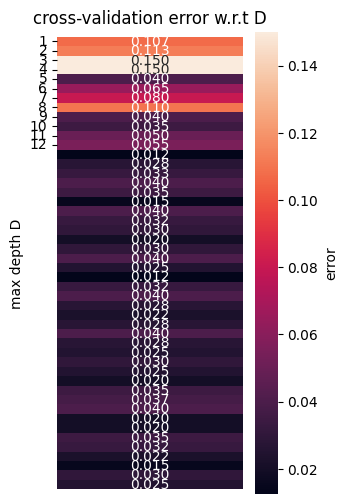

Best max depth D: 4
Test error: 0.030000000000000027
Train Accuracy: 0.99
Validation Accuracy: 0.9850000000000001


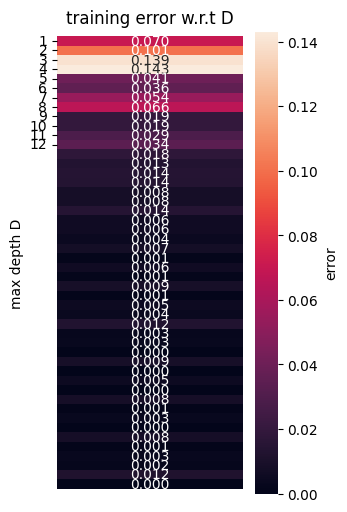

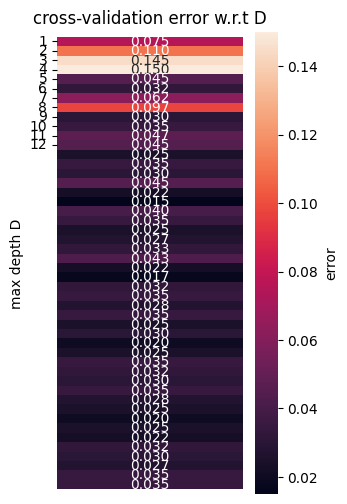

Best max depth D: 5
Test error: 0.024375000000000036


In [51]:
### Bagging family ###
BFtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split2X_train, Split2y_train)
        BFtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))

Partition: 0.2
Best C: 1, Best Gamma: 0.01
Train Accuracy: 0.995
Validation Accuracy: 0.9800000000000001


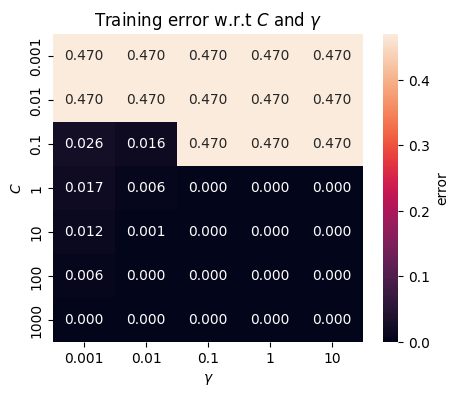

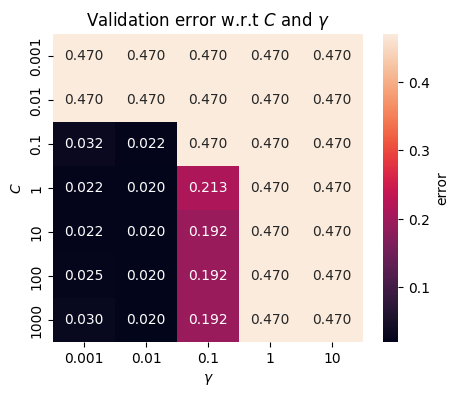

Best C: 0.1, Best Gamma: 0.01
Train Accuracy: 0.9925
Validation Accuracy: 0.99


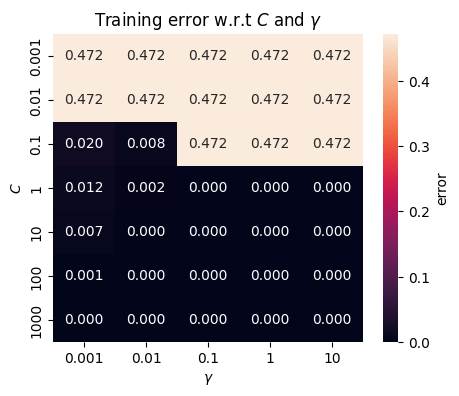

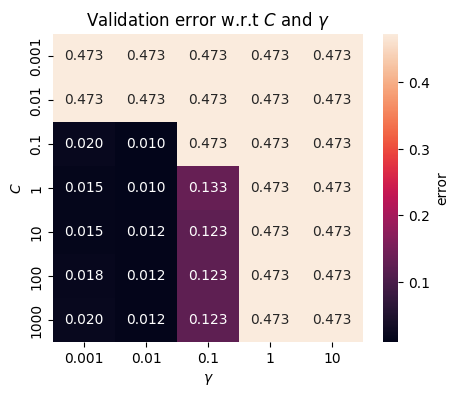

Best C: 1, Best Gamma: 0.01
Train Accuracy: 0.9975
Validation Accuracy: 0.9949999999999999


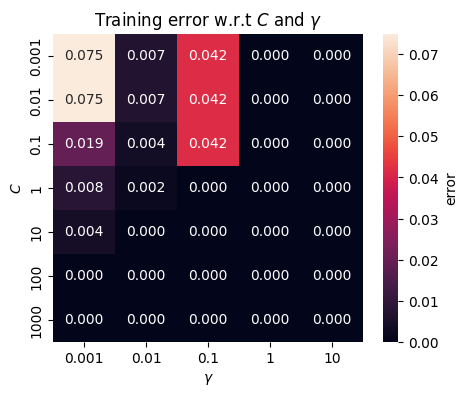

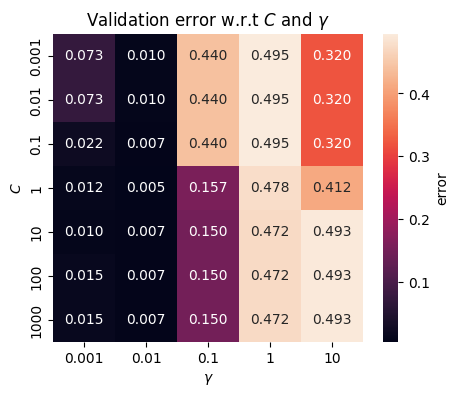

In [52]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.2]
trial = 3
testAccuracy_List3=[]
training_errors = np.zeros((len(C_list), len(gamma_list)))


#run 3 trials per partition
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=i)

        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split3X_train, Split3y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']

        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")

        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = classifier_Search.best_score_


        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma

        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split3X_train, Split3y_train)
        testAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))
        testAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))


## Best training accuracy with optimal Hyperparameter

In [53]:
### Report best training accuracies with their optimal hyperparameters. ###
print(f'Best training accuracy for Decision Tree: {DT_best_accuracy} with optimal hyperparameter D:{DTbest_max_depth_overall}.')
print(f'Best training accuracy for Random Forests: {RF_best_accuracy} with optimal hyperparameter D:{RFbest_max_depth_overall}.')
print(f'Best training accuracy for Bagging family: {BF_best_accuracy} with optimal hyperparameter D:{BFbest_max_depth_overall}.')
print(f'Best training accuracy for SVM w/RBF: {best_training_accuracy} with optimal hyperparameter C:{best_C_overall} and gamma:{best_gamma_overall}')

Best training accuracy for Decision Tree: 0.99 with optimal hyperparameter D:5.
Best training accuracy for Random Forests: 0.995 with optimal hyperparameter D:5.
Best training accuracy for Bagging family: 0.999375 with optimal hyperparameter D:9.
Best training accuracy for SVM w/RBF: 0.9975 with optimal hyperparameter C:1 and gamma:0.01


## Report test data respective average accuracy.

In [54]:
### Decision Tree ###
print(f'The average of the test accuracies for Decision Tree is: {sum(DTtestAccuracy_ListOverall) / len(DTtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for  80/20 split Decision Tree is: {sum(DTtestAccuracy_List1) / len(DTtestAccuracy_List1)}')
print(f'The average of the test accuracies for  50/50 split Decision Tree is: {sum(DTtestAccuracy_List2) / len(DTtestAccuracy_List2)}')
print(f'The average of the test accuracies for  20/80 split Decision Tree is: {sum(DTtestAccuracy_List3) / len(DTtestAccuracy_List3)}')

The average of the test accuracies for Decision Tree is: 0.9634583333333333
The average of the test accuracies for  80/20 split Decision Tree is: 0.9725
The average of the test accuracies for  50/50 split Decision Tree is: 0.9643333333333333
The average of the test accuracies for  20/80 split Decision Tree is: 0.9535416666666666


In [55]:
### Random Forests ###
print(f'The average of the test accuracies for Random Forests is: {sum(RFtestAccuracy_ListOverall) / len(RFtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 Random Forests is: {sum(RFtestAccuracy_List1) / len(RFtestAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 Random Forests is: {sum(RFtestAccuracy_List2) / len(RFtestAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 Random Forests is: {sum(RFtestAccuracy_List3) / len(RFtestAccuracy_List3)}')

The average of the test accuracies for Random Forests is: 0.9728194444444446
The average of the test accuracies for 80/20 Random Forests is: 0.9733333333333333
The average of the test accuracies for 50/50 Random Forests is: 0.9736666666666666
The average of the test accuracies for 20/80 Random Forests is: 0.9714583333333332


In [56]:
### Bagging family ### 
print(f'The average of the test accuracies for Bagging family is: {sum(BFtestAccuracy_ListOverall) / len(BFtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 Bagging family is: {sum(BFtestAccuracy_List1) / len(BFtestAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 Bagging family is: {sum(BFtestAccuracy_List2) / len(BFtestAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 Bagging family is: {sum(BFtestAccuracy_List3) / len(BFtestAccuracy_List3)}')

The average of the test accuracies for Bagging family is: 0.9776527777777777
The average of the test accuracies for 80/20 Bagging family is: 0.9733333333333333
The average of the test accuracies for 50/50 Bagging family is: 0.9756666666666667
The average of the test accuracies for 20/80 Bagging family is: 0.9839583333333333


In [57]:
### SVM w/RBF kernel ###
print(f'The average of the test accuracies for SVM w/RBF is: {sum(testAccuracy_ListOverall) / len(testAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 split SVM w/RBF is: {sum(testAccuracy_List1) / len(testAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 split SVM w/RBF is: {sum(testAccuracy_List2) / len(testAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 split SVM w/RBF is: {sum(testAccuracy_List3) / len(testAccuracy_List3)}')

The average of the test accuracies for SVM w/RBF is: 0.9839444444444445
The average of the test accuracies for 80/20 split SVM w/RBF is: 0.9866666666666667
The average of the test accuracies for 50/50 split SVM w/RBF is: 0.9843333333333334
The average of the test accuracies for 20/80 split SVM w/RBF is: 0.9808333333333333
